[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/susannaruecker/NLP-workshop/02_Word-Embeddings_FFN_RNN_fastText.ipynb)

In [1]:
import pandas as pd
import numpy as np
import nltk # a very handy NLP library (for simple but annoying things such as tokenization, stopwords, lemmatization) (also: spacy)
nltk.download('punkt')
!pip install wget
import os, gzip, wget, zipfile

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=4eee91af7cdb405cf62b1ace742eccf08d6449e4435983d8f10bed3494981166
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


# What we will do here:

* instead of BOW we want to use Word Embeddings now
* representing a token as a vector (Word Emedding)
* vectors capture meaning (similar words get similar vectors)
* text can be represented/processed as a _centroid_ (_bag-of-vectors_): averaging the word embeddings of the text (--> FFNs)
* or as a sequence (--> RNNs, (CNNs), Transformers)
* in this notebook you will find some kind of long helper functions, ignore them more or less... (loading embeddings, averaging them, ...)

* we will use pretrained embeddings (here: fastText, not very modern or "up to date", but for several languages), of course there are others (GloVe, ELMO, ...)
* before using them in a model, we just have a look into them

#### Helper function for downloading the German fastText vectors

(maybe not the prettiest way to do things...)

In [2]:
def load_fasttext_vectors(iso = "de", limit=None, target_path = 'fasttext/'):

    if not os.path.exists(target_path):
        print(f"creating folder {target_path}")
        os.makedirs(target_path)

    # if necessary download (german) fastText Embeddings
    url = f'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.{iso}.300.vec.gz'

    
    target_path = target_path + f'{iso}'
    print(target_path)
    if not os.path.isfile(target_path):
        print('downloading vectors...')
        wget.download(url, out=target_path)
        print('done')
    else:
        print('file already exists')

    print('loading embeddings ...')

    f = gzip.open(target_path, 'rb')
    n, d = map(int, f.readline().split())
    data = {}
    counter = 0
    for line in f:
        line = line.decode()
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(tokens[1:], dtype=np.float32)
        counter += 1
        if limit:
          if counter >= limit:
                break
    if limit:
        print(f"done loading embs WITH LIMIT {str(limit)}")
    else:
        print('done loading embs FULL')
    
    f.close()
    
    return data

In [3]:
# this will take some time...
embs = load_fasttext_vectors(iso = "de", limit=100000) # fastText file ist sorted by (decreasing) frequency, so for time reasons we only take the first N lines/words

creating folder fasttext/
fasttext/de
downloading vectors...
done
loading embeddings ...
done loading embs WITH LIMIT 100000


In [5]:
type(embs), len(embs) # here: a dictionray

(dict, 100000)

### Play around with fastText embeddings

In [6]:
embs.get("die")[:20] # makes sense, right? ;)

array([-0.0084,  0.0161,  0.1399, -0.0382, -0.0042,  0.2651,  0.0373,
        0.0522,  0.01  , -0.1401, -0.0171, -0.0086, -0.0979, -0.0401,
        0.012 , -0.0017, -0.0058, -0.0146,  0.0207, -0.0009],
      dtype=float32)

In [7]:
print(embs.get("die").shape) # 300 dimensions
embs_vocab = list(embs.keys())
print(len(embs_vocab)) # nr of known/used tokens
print(embs_vocab[:50]) # some of them (file is sorted by frequency, don't be confused!)

(300,)
100000
[',', '.', '</s>', 'und', 'der', ':', 'die', '"', ')', '(', 'in', 'von', 'den', 'mit', 'ist', 'für', 'zu', '/', 'das', 'im', 'auf', 'des', 'ein', 'nicht', 'dem', 'Die', 'eine', 'sich', '-', 'auch', 'als', "'", 'es', 'an', 'Sie', 'bei', 'ich', 'aus', '–', '!', 'er', 'oder', 'wurde', '?', 'sind', 'nach', 'werden', 'am', 'zum', '&']


In [18]:
sample = "Bald ist Weihnachten!"

for t in nltk.word_tokenize(sample):
  print(t, "\t", embs.get(t)[:5])

Bald 	 [ 0.0018  0.1447 -0.085   0.0583  0.0828]
ist 	 [-0.0717  0.0541  0.1029  0.03   -0.0219]
Weihnachten 	 [ 0.0196 -0.0234 -0.0085  0.0172  0.0059]
! 	 [-0.2462 -0.1792 -0.1634 -0.178  -0.0885]


In [17]:
from sklearn.metrics.pairwise import cosine_similarity

def similarity(a,b):
    vec1 = embs.get(a)
    vec2 = embs.get(b)
    return cosine_similarity(vec1.reshape(1,-1), vec2.reshape(1,-1)).squeeze()

print(similarity("Hund", "Katze"))
print(similarity("Katze", "Katze"))
print(similarity("Philosophie", "Katze"))
print(similarity("Philosophie", "Kunst"))

0.7219703
1.0
0.25203928
0.53908384


In [10]:
print(similarity("Hund", "hund")) # be careful, nothing is perfect...

0.69624454


# Some things to think about when using pretrained embeddings in real life:
* what language am I dealing with?
* dimensionality?
* vocab size, domain, what were they trained on, when, ...?
* always look into them: preprocessing of embeddings and your text data should be ideally) as similar as possible (sometimes not that easy...)
    * lemmatization, stemming, lower/capital, puctuation, stopwords...
* check what percentage of tokens are found in your embeddings (sometimes this is less than you would think)

# Back to our text classification task (10kGNAD)

(same steps as in BOW-notebook)

In [19]:
import requests
import os

os.makedirs('10kGNAD', exist_ok=True) # create folder in Colab

# download public 10kGNAD train and test data from github repo

url_train = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/train.csv'
read_train = requests.get(url_train, allow_redirects=True)
open('10kGNAD/train.csv', 'wb').write(read_train.content)

url_test = 'https://raw.githubusercontent.com/tblock/10kGNAD/master/test.csv'
read_test = requests.get(url_test, allow_redirects=True)
open('10kGNAD/test.csv', 'wb').write(read_test.content)

2755020

In [20]:
df_train = pd.read_csv("10kGNAD/train.csv", sep = ';', 
                       encoding = "utf-8", 
                       quotechar='\'', header=None, names = ["label", "article"])

df_test = pd.read_csv("10kGNAD/test.csv", sep = ';', 
                      encoding = "utf-8", 
                      quotechar='\'', header=None, names = ["label", "article"])

In [117]:
# use the LabelEncoder vom scklearn, and save the order/mapping for later
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
label_encoded=le.fit(df_train.label)
print(le.classes_)
label_names = le.classes_

label_to_id = {c: i for (i, c) in enumerate(le.classes_)}
print(label_to_id)

id_to_label = {v: k for k, v in label_to_id.items()}
print(id_to_label)

df_train["label_id"] = df_train.label.map(label_to_id)
df_test["label_id"] = df_test.label.map(label_to_id)

print("\nShapes:", df_train.shape, df_test.shape)

['Etat' 'Inland' 'International' 'Kultur' 'Panorama' 'Sport' 'Web'
 'Wirtschaft' 'Wissenschaft']
{'Etat': 0, 'Inland': 1, 'International': 2, 'Kultur': 3, 'Panorama': 4, 'Sport': 5, 'Web': 6, 'Wirtschaft': 7, 'Wissenschaft': 8}
{0: 'Etat', 1: 'Inland', 2: 'International', 3: 'Kultur', 4: 'Panorama', 5: 'Sport', 6: 'Web', 7: 'Wirtschaft', 8: 'Wissenschaft'}

Shapes: (9245, 3) (1028, 3)


In [26]:
# put the articles in two lists (not really necessary, but simpler for encoding them)
train_texts = df_train.article.values
test_texts = df_test.article.values

print(len(train_texts), len(test_texts))

9245 1028


In [27]:
train_texts[0][:400]

'21-Jähriger fällt wohl bis Saisonende aus. Wien – Rapid muss wohl bis Saisonende auf Offensivspieler Thomas Murg verzichten. Der im Winter aus Ried gekommene 21-Jährige erlitt beim 0:4-Heimdebakel gegen Admira Wacker Mödling am Samstag einen Teilriss des Innenbandes im linken Knie, wie eine Magnetresonanz-Untersuchung am Donnerstag ergab. Murg erhielt eine Schiene, muss aber nicht operiert werden.'

In [39]:
# labels
y_train = df_train.label_id.values
y_test = df_test.label_id.values
print(y_train.shape, y_test.shape)

(9245,) (1028,)


In [29]:
y_train, y_test

(array([5, 3, 6, ..., 7, 1, 4]), array([7, 5, 6, ..., 5, 5, 6]))

In [30]:
# Not used here. Remember: depends on if you use sparse_categorical_crossentropy or just categorical_crossentropy

# make labels into matrix
#from tensorflow.keras.utils import to_categorical
#y_train_matrix = to_categorical(y_train, dtype ="int")
#y_test_matrix = to_categorical(y_test, dtype ="int")

## First: Using _centroid_ or "bag of vectors" --> just averaging all word embeddings


In [31]:
# two helper functions for encoding text with embeddings

# used below
def get_centroid(text, embs, preprocessor = None, tokenizer= None, embs_dimension = 300, max_len = None):
    """
    centroid means ONE vector per document (= averaging all word vectors)
    returns vector and list of used tokens
    """
    vector = np.zeros(embs_dimension)
    if preprocessor: # if we have a specific preprocessor (dealing with lemmatization, stop words, capital letters, numbers ...)
        text = preprocessor(text)
    
    if tokenizer:
        tokens = tokenizer(text)
    
    else:
        tokens = nltk.word_tokenize(text)
    
    counter = 0
    used_tokens = []
    for n,t in enumerate(tokens):
        if t in embs:
            vector += embs.get(t)
            counter +=1
        used_tokens.append(t)
        if max_len:
            if n > max_len:
                break
    if counter !=0:
        vector = vector/counter
    return vector, used_tokens

# not used in model, but important for understanding difference
def get_embedding_matrix(text, embs, preprocessor = None, tokenizer=None, max_len=None):
    """
    embedding matrix, so each word embedding (n_tokens x embs_dimension)
    returns matrix and tokens (mapping between the two could helpful)
    """
    if preprocessor:
        text = preprocessor(text)

    if tokenizer:
        tokens = tokenizer(text)
    else: # use default nltk tokenizer
        tokens = nltk.word_tokenize(text)

    if max_len:
        if len(tokens) > max_len:
            tokens = tokens[:max_len] # truncate

    embs_dim = len(embs.get('und')) # take dummy entry to get dimensions of embs
    matrix = np.zeros((len(tokens), embs_dim))

    for i, t in enumerate(tokens):
        if t in embs:
            vector = embs.get(t)
        else:
            vector = np.zeros(embs_dim)
        matrix[i] = vector

    return matrix, tokens

In [32]:
sample = "Der Name INWT sagt den Embeddings leider nichts."
c_sample, t_sample = get_centroid(sample, embs)
print(c_sample.shape) # centroid vector
print(t_sample)       # these words were looked up in embeddings (UNKs get Zero-Vektor)

(300,)
['Der', 'Name', 'INWT', 'sagt', 'den', 'Embeddings', 'leider', 'nichts', '.']


In [34]:
# just for illustration: using a matrix instead
m_sample, t_sample = get_embedding_matrix(sample, embs)
print(m_sample.shape)
print(m_sample)
print(t_sample)

(9, 300)
[[-0.0369  0.0201  0.0429 ...  0.0111 -0.2723 -0.0594]
 [-0.1655  0.0517 -0.1398 ... -0.1001  0.0999 -0.1132]
 [ 0.      0.      0.     ...  0.      0.      0.    ]
 ...
 [-0.0266  0.0018 -0.0154 ...  0.0164  0.0056 -0.0399]
 [ 0.0104  0.0125  0.0224 ... -0.0373  0.0725  0.0033]
 [-0.0257  0.0093 -0.0562 ...  0.0404 -0.0495 -0.0133]]
['Der', 'Name', 'INWT', 'sagt', 'den', 'Embeddings', 'leider', 'nichts', '.']


### Creating Features (centroid vectors), using the helper function:

In [36]:
train_centroid = np.array([ get_centroid(t, embs, embs_dimension=300)[0] for t in train_texts ])
test_centroid = np.array([ get_centroid(t, embs, embs_dimension=300)[0] for t in test_texts ])

In [37]:
print(train_centroid.shape)
print(test_centroid.shape)

(9245, 300)
(1028, 300)


In [38]:
train_centroid[0][:10] # this is what one text looks like now

array([-0.012875  ,  0.01537344,  0.00363125,  0.03094375,  0.0268375 ,
        0.03983594, -0.01309062,  0.0186375 , -0.00454219, -0.02673906])

### Creating the model, still a simple FFN (one text is one vector, still not a sequence)

In [40]:
import tensorflow as tf

ffn = tf.keras.Sequential([
    tf.keras.Input(shape=(300,)), # 300 in embedding dimension
    #tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(9, activation='softmax')
])
ffn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                19264     
                                                                 
 dense_1 (Dense)             (None, 9)                 585       
                                                                 
Total params: 19,849
Trainable params: 19,849
Non-trainable params: 0
_________________________________________________________________


In [41]:
ffn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [42]:
history = ffn.fit(train_centroid, y_train, epochs=80, batch_size=64, verbose=1,
                   validation_data=(test_centroid, y_test))

Epoch 1/80
145/145 [==============================] - 2s 5ms/step - loss: 2.1351 - accuracy: 0.1827 - val_loss: 2.0853 - val_accuracy: 0.1858
Epoch 2/80
145/145 [==============================] - 1s 4ms/step - loss: 2.0666 - accuracy: 0.2908 - val_loss: 2.0410 - val_accuracy: 0.3434
Epoch 3/80
145/145 [==============================] - 0s 3ms/step - loss: 2.0213 - accuracy: 0.3504 - val_loss: 1.9893 - val_accuracy: 0.3249
Epoch 4/80
145/145 [==============================] - 1s 4ms/step - loss: 1.9699 - accuracy: 0.3785 - val_loss: 1.9347 - val_accuracy: 0.4990
Epoch 5/80
145/145 [==============================] - 1s 4ms/step - loss: 1.9134 - accuracy: 0.4214 - val_loss: 1.8708 - val_accuracy: 0.4008
Epoch 6/80
145/145 [==============================] - 1s 4ms/step - loss: 1.8526 - accuracy: 0.4420 - val_loss: 1.8046 - val_accuracy: 0.4698
Epoch 7/80
145/145 [==============================] - 0s 3ms/step - loss: 1.7886 - accuracy: 0.4632 - val_loss: 1.7399 - val_accuracy: 0.4903
Epoch 

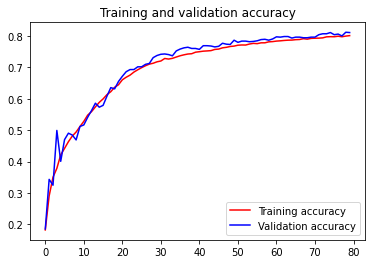

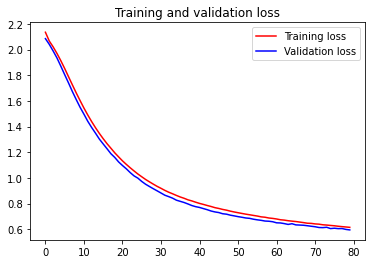

<Figure size 432x288 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

### Predicting or new texts

In [44]:
new_texts = [
             """Der Südbadische Fußballverband (SBFV) hat auf die aktuelle Entwicklung in der Corona-Pandemie reagiert. Der Verbandsvorstand beschloss am Abend, mit dem Spielbetrieb in allen 
             südbadischen Alters- und Spielklassen von der Verbandsliga abwärts vorzeitig in die Winterpause zu gehen.""",
             
             """Vor dem Bund-Länder-Gespräch über weitere Einschränkungen und Verbote werden die Forderungen nach einem harten Lockdown lauter. Der Präsident des Städtetages Baden-Württemberg, 
             Mannheims Oberbürgermeister Peter Kurz (SPD), hält ihn für nötig, wenn sich die Corona-Lage in den kommenden Tagen weiter verschärft.
             """,
             
             """Dank einer taktischen Umstellung für die letzten fünf Spielminuten und dem viel zitierten Spielglück haben die Basketballerinnen des USC Freiburg ihren Heimnimbus in dieser Saison gewahrt und sich in der 
             Spitzengruppe der Bundesliga festgekrallt. Am Samstagabend gewannen die Eisvögel im sechsten Spiel in der Unihalle zum sechsten Mal
             """,
             
             """Abgesehen von pandemiegeschuldeter Einlasskontrolle und Maskenpflicht war es wie früher: das Freiburger Konzerthaus – ausverkauft! Kein Wunder, wenn die aus Südbaden stammende Weltklasse-Geigerin 
             Anne-Sophie Mutter und ihre seit nunmehr zehn Jahren bestehenden Mutter’s Virtuosi auftreten. Mittelpunkt und Rahmen jetzt: Antonio Vivaldi.
             """,
             
             """Ja, es ist ein Jugendstück. Anton Tschechow war 18 Jahre alt, als er es schrieb - und wieder vernichtete, nachdem es kein Gehör gefunden hatte. 
             Die Erstschrift hat sich erhalten und wurde 1920 unter dem – nicht von Tschechow stammenden – Titel "Platonow" veröffentlicht. Eine Jugendsünde ist es nicht, 
             denn viele Motive aus dem späteren Werk klingen an. Nur: Wenn man es vom Blatt spielte, dauerte die Aufführung geschlagene sechs Stunden, länger als jede Wagner-Oper. 
             """,

             #
             # feel free to be creative and write your own test arcticle! :)
             #
]

In [46]:
# remeber what you did earlier? repeat!
X_centroid = np.array([ get_centroid(t, embs, embs_dimension=300)[0] for t in new_texts ])

In [47]:
probs = ffn.predict(X_centroid)
#print(probs)
#print("----")

labels = np.argmax(probs,axis=1)
print(labels)
print("----")

print( [ (l, id_to_label[l]) for l in labels]) # sieht gut aus, Abweichungen zum BOW-Modell sind vorhanden, aber Texte sind auch nicht eindeutig

[5 2 5 3 3]
----
[(5, 'Sport'), (2, 'International'), (5, 'Sport'), (3, 'Kultur'), (3, 'Kultur')]


In [49]:
id_to_label # just to remember what labels we have

{0: 'Etat',
 1: 'Inland',
 2: 'International',
 3: 'Kultur',
 4: 'Panorama',
 5: 'Sport',
 6: 'Web',
 7: 'Wirtschaft',
 8: 'Wissenschaft'}

# ... Done with the fist part of the notebook :)

(I didn't start a new one because we still need the embeddings.)


---


# Now: RNN, so looking at text as a sequence, not just one vector

* using embedding layer in keras
* first: using them "from scratch" (so without any pretrained weights)
* then: loading weights from your fastText embeddings

### 1. Get padded sequences (with token ids) from the texts

* define vocab size, OOV-token, and fixed length
* tokenize text to id lists (specific mapping is used, take a look at it)
* pad/truncate those lists to same length

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

VOCAB_SIZE = 10000           # note: to low means a lot of unknown words, to high means potentially very sparse features AND huge size of parameters in embedding layer
OOV_TOKEN = "<OOV>"
FIXED_LEN = 500              # length of sequence, every text gets truncated or padded to this size --> so we can process in batches even though texts have different length

tokenizer = Tokenizer(num_words = VOCAB_SIZE,   # define how many unique words you want to have inyout vocabulary
                      oov_token=OOV_TOKEN,      # define what to assign to out-of-vocabulary tokens
                      lower=False)              # Achtung wichtig, defaults to True, die Embeddings sind aber nicht lower cased, daher für mapping False setzen!

tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

print(len(word_index)) # this is indeed confusing... the word_index still lists ALL unique words (ignorrin num_words), only later on all OOV-tokens get labeled as "OOV" (1)

train_ids = tokenizer.texts_to_sequences(train_texts)                                           # this is a list of id lists of still different sizes
train_padded = pad_sequences(train_ids,maxlen=FIXED_LEN, truncating="post", padding = "post")   # this does the padding/truncating

test_ids = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_ids,maxlen=FIXED_LEN, truncating="post", padding = "post")


189019


In [68]:
print(len(train_ids[0])) # first text
print(len(train_ids[1]))
print(len(train_ids[2]))

68
587
289


In [69]:
print(train_padded.shape, test_padded.shape) # now padded

(9245, 500) (1028, 500)


In [70]:
train_texts[1]

'Erfundene Bilder zu Filmen, die als verloren gelten: "The Forbidden Room" von Guy Maddin und Evan Johnson ist ein surrealer Ritt durch die magischen Labyrinthe des frühen Kinos. Wien – Die Filmgeschichte ist ein Friedhof der Verlorenen. Unter den Begrabenen finden sich zahllose Filme, von denen nur noch mysteriös oder abenteuerlich klingende Namen kursieren; und solche, über die verstreut herumliegendes Sekundärmaterial Aufschluss erlaubt. Einer davon ist The Forbidden Room, ein Two-Reeler von 1913/14, den der arbeitswütige US-Regisseur Allan Dwan u. a. mit dem Horrordarsteller Lon Chaney gedreht hat. Ein passender Titel für einen Film, der als verschollen gilt. Verbote sind Einladungen zur Überschreitung. Einen ähnlichen Gedanken hatte wohl auch der kanadische Experimentalfilmemacher Guy Maddin, als er seinem Film von 2015 den gleichen Titel gab. Gemeinsam mit seinem Koregisseur Evan Johnson hat er vergessene, verschwundene Arbeiten der Film geschichte zum Ausgangspunkt einer Neuerfi

In [75]:
# this is one text, so the input for our future model

train_padded[1] # 1 is id for "OOV" so token that is unknown to the tokenizer (play around with VOCAB_SIZE)

array([   1, 1042,    8, 4001,    3,   25,  730, 1105,  553,    1,    1,
          7,    1,    1,    4,    1, 7212,   13,   19,    1,    1,   74,
          3,    1,    1,   22, 1773, 7327,   69,   17,   18,    1,   13,
         19, 9552,    2,    1,  685,    6,    1,  410,   16,    1, 2527,
          7,  282,   52,   47,    1,   56,    1,    1,  701,    1,    4,
        575,   50,    3,    1,    1,    1,    1, 1635, 1622,  233,   13,
        553,    1,    1,   19,    1,    1,    7,    1,  331,    6,    2,
          1,  132, 2338,    1,    1, 2358,  890,    9,   20,    1,    1,
          1, 6137,   30,  109,    1,  661,   14,   46,  852,    2,   25,
          1,  332,    1,   44,    1,   66,    1, 1043, 3705, 3391,   63,
        304,   24,    2,    1,    1,    1,    1,   25,   35,  203,  852,
          7,  157,    6, 1528,  661,  182, 3355,    9,  203,    1,    1,
       7212,   30,   35,    1,    1, 2102,    2,  852,    1,   58, 9553,
         36,    1,    1,  476, 4416,    1,  144,   

#### Just getting a bit more confortable with what we're dealing with:

In [72]:
# look at some tokens and their ids in the tokenizer vocab
# good to know: starts with 1 ("OOV"), then normal tokens
for n, (w,i) in enumerate(tokenizer.word_index.items()):
    print(n, w, i)
    if n >= 20:
        break

0 <OOV> 1
1 der 2
2 die 3
3 und 4
4 in 5
5 den 6
6 von 7
7 zu 8
8 mit 9
9 das 10
10 auf 11
11 im 12
12 ist 13
13 für 14
14 nicht 15
15 sich 16
16 – 17
17 Die 18
18 ein 19
19 dem 20
20 es 21


In [76]:
# other way around, might be useful later
id_to_token = {v: k for k, v in tokenizer.word_index.items()}

In [77]:
for n, (w,i) in enumerate(id_to_token.items()):
    print(w, i)
    if n >= 10:
        break

1 <OOV>
2 der
3 die
4 und
5 in
6 den
7 von
8 zu
9 mit
10 das
11 auf


In [78]:
tokenizer.word_index.get("Bilder")

1042

In [79]:
tokenizer.word_index.get("Das")

38

In [80]:
id_to_token[38]

'Das'

## Okay, now: How to combine this (encoding of text as padded sequences of token ids) with our fastText-Embeddings?

Note: **Just if we want to use pretrained embeddings, otherwise we dont need to do all of the following!**

--> We need to build a look-up / mapping that gets the embedding vector from the token_id

(this is how the Keras-Embeddings layers expect it to be) 

In [83]:
# remember our fastText-embeddings?
embs.get("Bilder")[:50]

array([ 0.0065,  0.0012,  0.0464,  0.0303,  0.0143,  0.0158,  0.0109,
        0.0297, -0.0472,  0.0616, -0.0287, -0.0106,  0.002 , -0.0144,
       -0.0221,  0.0188,  0.0331, -0.0114, -0.0634, -0.0446,  0.0582,
        0.01  ,  0.0828,  0.0501,  0.0088, -0.014 , -0.0507,  0.0036,
       -0.0061, -0.0531,  0.0702,  0.0329, -0.0769, -0.0434, -0.0235,
        0.0207,  0.0249,  0.0483,  0.0234, -0.0067, -0.02  , -0.0268,
        0.0092,  0.0193, -0.0365,  0.0091, -0.0188, -0.002 , -0.0336,
        0.0071], dtype=float32)

In [84]:
EMBEDDING_DIM = 300 # this is the given length of the fastText vectors, other embeddings could be different, needs to be looked up!

In [85]:
# create a dummy matrix (zeros) with the right shape:
embedding_matrix = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM)) # +1 because "OOV"

# fill it with the embeddings:
for id, token in id_to_token.items():
    embedding_vector = embs.get(token)
    if id <= VOCAB_SIZE:
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[id] = embedding_vector

In [86]:
embedding_matrix.shape

(10001, 300)

In [87]:
embedding_matrix[:10] # I think the first line is kind of useless but necessary because word_index starts with 1 ...?

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0159    ,  0.0473    ,  0.1034    , ...,  0.0465    ,
         0.0605    , -0.0628    ],
       ...,
       [-0.0747    ,  0.0011    ,  0.0081    , ...,  0.0517    ,
         0.0655    , -0.0553    ],
       [ 0.0148    , -0.053     , -0.2757    , ..., -0.0918    ,
         0.38069999,  0.0483    ],
       [-0.0456    , -0.0014    ,  0.036     , ..., -0.001     ,
         0.0139    , -0.1026    ]])

In [95]:
# chek if everything seems good:
print(word_index.get("für"))
print(id_to_token[14])

print(embedding_matrix[14][:8]) # check!
print(embs.get("für")[:8]) # check!

14
für
[-0.0159  0.0294  0.0486 -0.0102  0.0123  0.0941 -0.0594  0.0134]
[-0.0159  0.0294  0.0486 -0.0102  0.0123  0.0941 -0.0594  0.0134]


# Now (finally!) to the RNN models -- 3 variants

* model1 : not using the pretrained embeddings, so just plain embedding layer
   * (so the whole loading embeddings and creating embedding_matrix circus is not necessary, in constrast to the still needed padded_sequence as input!)
* model2 : using the pretrained embeddings (our embedding_matrix lookup), but FREEZING them
* model3 : same as model2 but WITH Fine Tuning embeddings weights

# Note: training each does take time even on GPU!

In [99]:
import tensorflow as tf

model1 = tf.keras.Sequential([
    
    # variant 1: without initializing weights, just plain embedding layer
    tf.keras.layers.Embedding(VOCAB_SIZE + 1, EMBEDDING_DIM), # in this case (different to variants below!) EMBEDING_DIM could be any, doesn't need to be 300
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(9, activation='softmax')
])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         3000300   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 9)                 297       
                                                                 
Total params: 3,191,605
Trainable params: 3,191,605
Non-trainable params: 0
____________________________________________

In [100]:
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [101]:
history1 = model1.fit(train_padded, y_train, epochs=15, batch_size=64, verbose=1,
                      validation_data=(test_padded, y_test))

Epoch 1/15
145/145 [==============================] - 28s 169ms/step - loss: 1.9729 - accuracy: 0.2662 - val_loss: 1.6730 - val_accuracy: 0.3891
Epoch 2/15
145/145 [==============================] - 24s 163ms/step - loss: 1.4575 - accuracy: 0.4760 - val_loss: 1.3726 - val_accuracy: 0.5156
Epoch 3/15
145/145 [==============================] - 24s 163ms/step - loss: 1.2831 - accuracy: 0.5753 - val_loss: 1.3358 - val_accuracy: 0.5574
Epoch 4/15
145/145 [==============================] - 24s 163ms/step - loss: 0.9422 - accuracy: 0.7045 - val_loss: 1.1303 - val_accuracy: 0.6274
Epoch 5/15
145/145 [==============================] - 24s 163ms/step - loss: 0.6523 - accuracy: 0.8045 - val_loss: 1.0465 - val_accuracy: 0.6702
Epoch 6/15
145/145 [==============================] - 24s 163ms/step - loss: 0.4809 - accuracy: 0.8635 - val_loss: 1.1071 - val_accuracy: 0.6556
Epoch 7/15
145/145 [==============================] - 24s 163ms/step - loss: 0.3860 - accuracy: 0.8937 - val_loss: 1.0946 - val_ac

In [103]:
model1.evaluate(test_padded, y_test)

33/33 [==============================] - 2s 75ms/step - loss: 1.2943 - accuracy: 0.7228


[1.294263482093811, 0.7227626442909241]

In [106]:
model2 = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(VOCAB_SIZE + 1,
                              EMBEDDING_DIM,
                              weights=[embedding_matrix], # using our embedding_matrix
                              input_length=FIXED_LEN,
                              trainable=False # set True or False, so whether to use freezed embeddings or fine tune them
                              ),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(9, activation='softmax')
])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 300)          3000300   
                                                                 
 dropout_1 (Dropout)         (None, 500, 300)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dense_7 (Dense)             (None, 9)                 297       
                                                                 
Total params: 3,191,605
Trainable params: 191,305
Non-trainable params: 3,000,300
______________________________________

In [107]:
model2.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [108]:
history2 = model2.fit(train_padded, y_train, epochs=15, batch_size=64, verbose=1,
                      validation_data=(test_padded, y_test))

Epoch 1/15
145/145 [==============================] - 27s 162ms/step - loss: 2.1173 - accuracy: 0.1970 - val_loss: 2.0144 - val_accuracy: 0.2840
Epoch 2/15
145/145 [==============================] - 22s 152ms/step - loss: 1.9212 - accuracy: 0.3063 - val_loss: 1.8883 - val_accuracy: 0.3045
Epoch 3/15
145/145 [==============================] - 22s 152ms/step - loss: 1.7207 - accuracy: 0.3801 - val_loss: 1.6066 - val_accuracy: 0.3706
Epoch 4/15
145/145 [==============================] - 22s 152ms/step - loss: 1.7364 - accuracy: 0.3585 - val_loss: 1.6084 - val_accuracy: 0.4183
Epoch 5/15
145/145 [==============================] - 22s 152ms/step - loss: 1.5289 - accuracy: 0.4627 - val_loss: 1.3905 - val_accuracy: 0.5010
Epoch 6/15
145/145 [==============================] - 22s 152ms/step - loss: 1.4193 - accuracy: 0.4836 - val_loss: 1.3139 - val_accuracy: 0.5292
Epoch 7/15
145/145 [==============================] - 22s 152ms/step - loss: 1.3119 - accuracy: 0.5415 - val_loss: 1.2562 - val_ac

In [109]:
model3 = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(VOCAB_SIZE + 1,
                              EMBEDDING_DIM,
                              weights=[embedding_matrix], # using our embedding_matrix
                              input_length=FIXED_LEN,
                              trainable=True # AND fine tune the embeddings as well (a LOT more parameters to train)
                              ),
    tf.keras.layers.Dropout(0.2),    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(9, activation='softmax')
])

model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 300)          3000300   
                                                                 
 dropout_2 (Dropout)         (None, 500, 300)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 9)                 297       
                                                                 
Total params: 3,191,605
Trainable params: 3,191,605
Non-trainable params: 0
____________________________________________

In [110]:
model3.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [111]:
history3 = model3.fit(train_padded, y_train, epochs=15, batch_size=64, verbose=1,
                      validation_data=(test_padded, y_test))

Epoch 1/15
145/145 [==============================] - 29s 169ms/step - loss: 2.0860 - accuracy: 0.2243 - val_loss: 1.9693 - val_accuracy: 0.3074
Epoch 2/15
145/145 [==============================] - 24s 162ms/step - loss: 1.6230 - accuracy: 0.4792 - val_loss: 1.3283 - val_accuracy: 0.5759
Epoch 3/15
145/145 [==============================] - 23s 162ms/step - loss: 1.1452 - accuracy: 0.6469 - val_loss: 1.2444 - val_accuracy: 0.5924
Epoch 4/15
145/145 [==============================] - 23s 162ms/step - loss: 0.9412 - accuracy: 0.7085 - val_loss: 1.1981 - val_accuracy: 0.5944
Epoch 5/15
145/145 [==============================] - 24s 162ms/step - loss: 0.6915 - accuracy: 0.7951 - val_loss: 0.9425 - val_accuracy: 0.6897
Epoch 6/15
145/145 [==============================] - 24s 163ms/step - loss: 0.4657 - accuracy: 0.8792 - val_loss: 0.9380 - val_accuracy: 0.7140
Epoch 7/15
145/145 [==============================] - 24s 162ms/step - loss: 0.3182 - accuracy: 0.9334 - val_loss: 0.9583 - val_ac

In [112]:
import matplotlib.pyplot as plt

def print_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()

    plt.show()

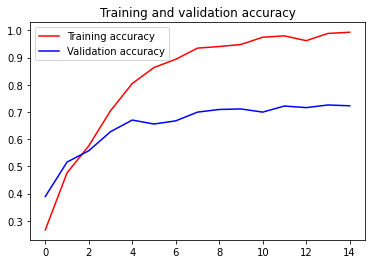

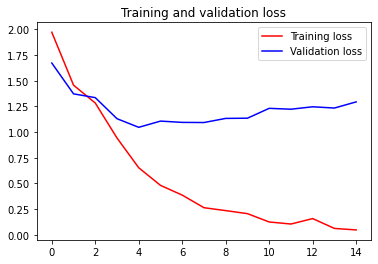

<Figure size 432x288 with 0 Axes>

In [113]:
print_history(history1)

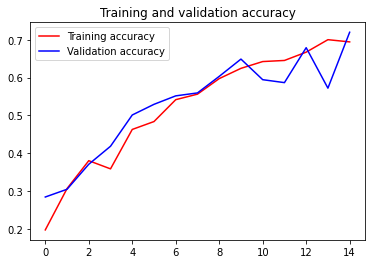

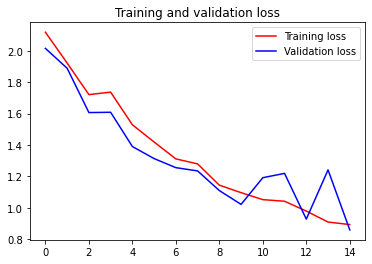

<Figure size 432x288 with 0 Axes>

In [114]:
print_history(history2)

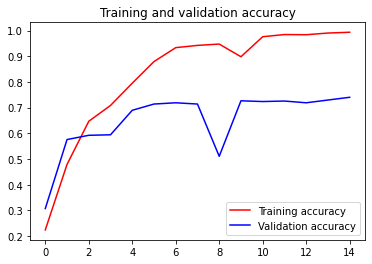

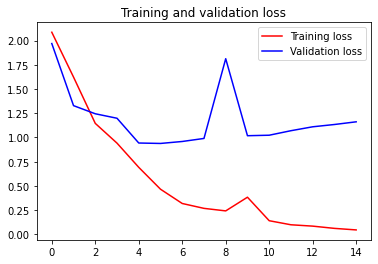

<Figure size 432x288 with 0 Axes>

In [115]:
print_history(history3)

In [118]:
### of course we can always look at the performance by label, e.g. using the classification report (like in the BOW notebook)
from sklearn.metrics import classification_report

pred_test_prob = model2.predict(test_padded)
print(pred_test_prob[0])
pred_test =np.argmax(pred_test_prob,axis=1)
print(pred_test[0])
print("----")
print(classification_report(y_test, pred_test, target_names=label_names))

[0.04235559 0.04061202 0.00567512 0.03340151 0.0357483  0.00591849
 0.04135846 0.6872836  0.107647  ]
7
----
               precision    recall  f1-score   support

         Etat       0.56      0.42      0.48        67
       Inland       0.74      0.53      0.62       102
International       0.77      0.77      0.77       151
       Kultur       0.62      0.74      0.67        54
     Panorama       0.62      0.60      0.61       168
        Sport       0.92      0.97      0.95       120
          Web       0.90      0.87      0.88       168
   Wirtschaft       0.56      0.84      0.67       141
 Wissenschaft       0.80      0.35      0.49        57

     accuracy                           0.72      1028
    macro avg       0.72      0.68      0.68      1028
 weighted avg       0.73      0.72      0.71      1028



## Back to our unseen new texts!

#### Remeber: We always need the same preprocessing!
#### So here: `text_to_sequence` --> `pad_sequence`

In [119]:
new_texts # still in memory, if not look above

['Der Südbadische Fußballverband (SBFV) hat auf die aktuelle Entwicklung in der Corona-Pandemie reagiert. Der Verbandsvorstand beschloss am Abend, mit dem Spielbetrieb in allen \n             südbadischen Alters- und Spielklassen von der Verbandsliga abwärts vorzeitig in die Winterpause zu gehen.',
 'Vor dem Bund-Länder-Gespräch über weitere Einschränkungen und Verbote werden die Forderungen nach einem harten Lockdown lauter. Der Präsident des Städtetages Baden-Württemberg, \n             Mannheims Oberbürgermeister Peter Kurz (SPD), hält ihn für nötig, wenn sich die Corona-Lage in den kommenden Tagen weiter verschärft.\n             ',
 'Dank einer taktischen Umstellung für die letzten fünf Spielminuten und dem viel zitierten Spielglück haben die Basketballerinnen des USC Freiburg ihren Heimnimbus in dieser Saison gewahrt und sich in der \n             Spitzengruppe der Bundesliga festgekrallt. Am Samstagabend gewannen die Eisvögel im sechsten Spiel in der Unihalle zum sechsten Mal\n 

In [120]:
X_ids = tokenizer.texts_to_sequences(new_texts)

In [121]:
X_ids[0][:20] # first 20 words in first text

[33, 1, 1, 1, 30, 11, 3, 1170, 544, 5, 2, 1, 1, 1832, 33, 1, 6687, 27, 984, 9]

In [122]:
X_padded = pad_sequences(X_ids, maxlen=FIXED_LEN, truncating="post", padding = "post")

In [123]:
X_padded

array([[  33,    1,    1, ...,    0,    0,    0],
       [ 333,   20,  919, ...,    0,    0,    0],
       [2880,   36,    1, ...,    0,    0,    0],
       [6726,    7,    1, ...,    0,    0,    0],
       [ 813,   21,   13, ...,    0,    0,    0]], dtype=int32)

In [124]:
probs = model3.predict(X_padded) # play around with the 3 model variants
#print(probs)
#print("----")

labels = np.argmax(probs,axis=1)
print(labels)
print("----")

print( [ (l, id_to_label[l]) for l in labels]) # a bit funny sometimes ... :D

[3 7 1 8 3]
----
[(3, 'Kultur'), (7, 'Wirtschaft'), (1, 'Inland'), (8, 'Wissenschaft'), (3, 'Kultur')]
